# Lun 416B cell line (Smart-seq2) workflow

This is a reimplemintation of the [Lun 416B workflow from OSCA Ch. 23](https://osca.bioconductor.org/lun-416b-cell-line-smart-seq2.html). Analysis is done here using both R Bioconductor (implemented with rpy2) and the Python [Scanpy package](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/index.html). Components drawn from the [Theis Lab Scanpy Single Cell Tutorial](https://github.com/theislab/single-cell-tutorial).

From OSCA:

The A. T. L. Lun et al. ([2017](https://www.ncbi.nlm.nih.gov/pubmed/29030468)) dataset contains two 96-well plates of 416B cells (an immortalized mouse myeloid progenitor cell line), processed using the Smart-seq2 protocol (Picelli et al. [2014](https://www.nature.com/articles/nprot.2014.006)). A constant amount of spike-in RNA from the External RNA Controls Consortium (ERCC) was also added to each cell’s lysate prior to library preparation. High-throughput sequencing was performed and the expression of each gene was quantified by counting the total number of reads mapped to its exonic regions. Similarly, the quantity of each spike-in transcript was measured by counting the number of reads mapped to the spike-in reference sequences.

## 0. Load Packages

In [41]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.spatial import distance
import seaborn as sns
sns.set()

import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

In [42]:
# Ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes, and activate anndata2ri 
# for converting to/from AnnData objects
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Set up scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
scanpy==1.4.5.post2 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [43]:
%%R
# Load all the required R libraries
library(scran)
library(scRNAseq)
library(AnnotationHub)
library(scater)

## 1. Data loading and preprocessing
Done in R.

In [44]:
%%R

# Load data. Convert block to a factor variable
sce.416b <- LunSpikeInData(which="416b") 
sce.416b$block <- factor(sce.416b$block)

# Rename rows with symbols
ens.mm.v97 <- AnnotationHub()[["AH73905"]]
rowData(sce.416b)$ENSEMBL <- rownames(sce.416b)
rowData(sce.416b)$SYMBOL <- mapIds(ens.mm.v97, keys=rownames(sce.416b),
    keytype="GENEID", column="SYMBOL")
rowData(sce.416b)$SEQNAME <- mapIds(ens.mm.v97, keys=rownames(sce.416b),
    keytype="GENEID", column="SEQNAME")
rownames(sce.416b) <- uniquifyFeatureNames(rowData(sce.416b)$ENSEMBL, 
                                           rowData(sce.416b)$SYMBOL)

## 2. Quality control
Also done fully in R; scanpy does not provide analogous functions.

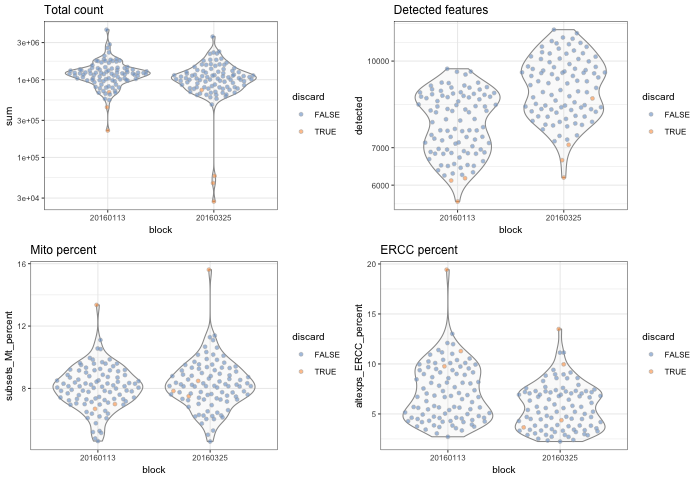

In [45]:
%%R -w 700

# Save an unfiltered copy 
unfiltered <- sce.416b

# Calculate mitochondrial proportions
mito <- which(rowData(sce.416b)$SEQNAME=="MT")
stats <- perCellQCMetrics(sce.416b, subsets=list(Mt=mito))
qc <- quickPerCellQC(stats, percent_subsets=c("subsets_Mt_percent",
    "altexps_ERCC_percent"), batch=sce.416b$block)
sce.416b <- sce.416b[,!qc$discard]

# Discard cells
colData(unfiltered) <- cbind(colData(unfiltered), stats)
unfiltered$block <- factor(unfiltered$block)
unfiltered$discard <- qc$discard

gridExtra::grid.arrange(
    plotColData(unfiltered, x="block", y="sum", 
        colour_by="discard") + scale_y_log10() + ggtitle("Total count"),
    plotColData(unfiltered, x="block", y="detected", 
        colour_by="discard") + scale_y_log10() + ggtitle("Detected features"),
    plotColData(unfiltered, x="block", y="subsets_Mt_percent", 
        colour_by="discard") + ggtitle("Mito percent"),
    plotColData(unfiltered, x="block", y="altexps_ERCC_percent", 
        colour_by="discard") + ggtitle("ERCC percent"),
    nrow=2,
    ncol=2
)

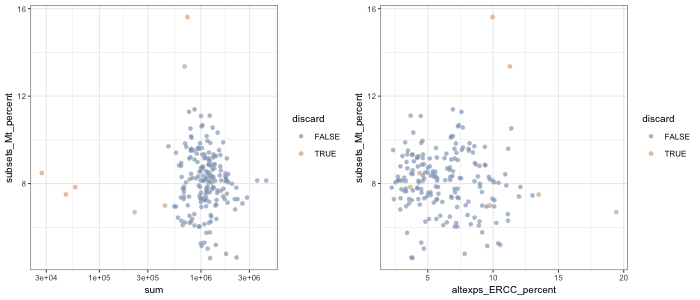

In [46]:
%%R -w 700 -h 300
gridExtra::grid.arrange(
    plotColData(unfiltered, x="sum", y="subsets_Mt_percent", 
        colour_by="discard") + scale_x_log10(),
    plotColData(unfiltered, x="altexps_ERCC_percent", y="subsets_Mt_percent",
        colour_by="discard"),
    ncol=2
)

## 3. Normalization
At this point, we convert the R SingleCellExperiment to a Python AnnData object. Scanpy only provides normalization by library size, so we use the R scran package for normalization by deconvolution.

In [47]:
%%R -o adata

# Convert to AnnData object
adata <- as(sce.416b, 'SingleCellExperiment')

In [48]:
adata

AnnData object with n_obs × n_vars = 185 × 46604 
    obs: 'Source Name', 'cell line', 'cell type', 'single cell well quality', 'genotype', 'phenotype', 'strain', 'spike-in addition', 'block'
    var: 'Length', 'ENSEMBL', 'SYMBOL', 'SEQNAME'

In [9]:
# Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [10]:
# Create copy for library size normalization
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, key_added='lib_size_factors')

normalizing counts per cell
    finished (0:00:00)


In [11]:
# Prepare input for scran normalization
data_mat = adata.X.T

In [12]:
%%R -i data_mat -o size_factors
size_factors = calculateSumFactors(data_mat)

In [13]:
adata.obs['size_factors'] = size_factors
adata.obs['lib_size_factors'] = adata_pp.obs['lib_size_factors']

del adata_pp

# Lognormalize the data
sc.pp.log1p(adata)

In [14]:
# Extract induced cells
induced = adata.obs.phenotype.str.find('induced')

Text(0.5, 0, 'Library size factors')

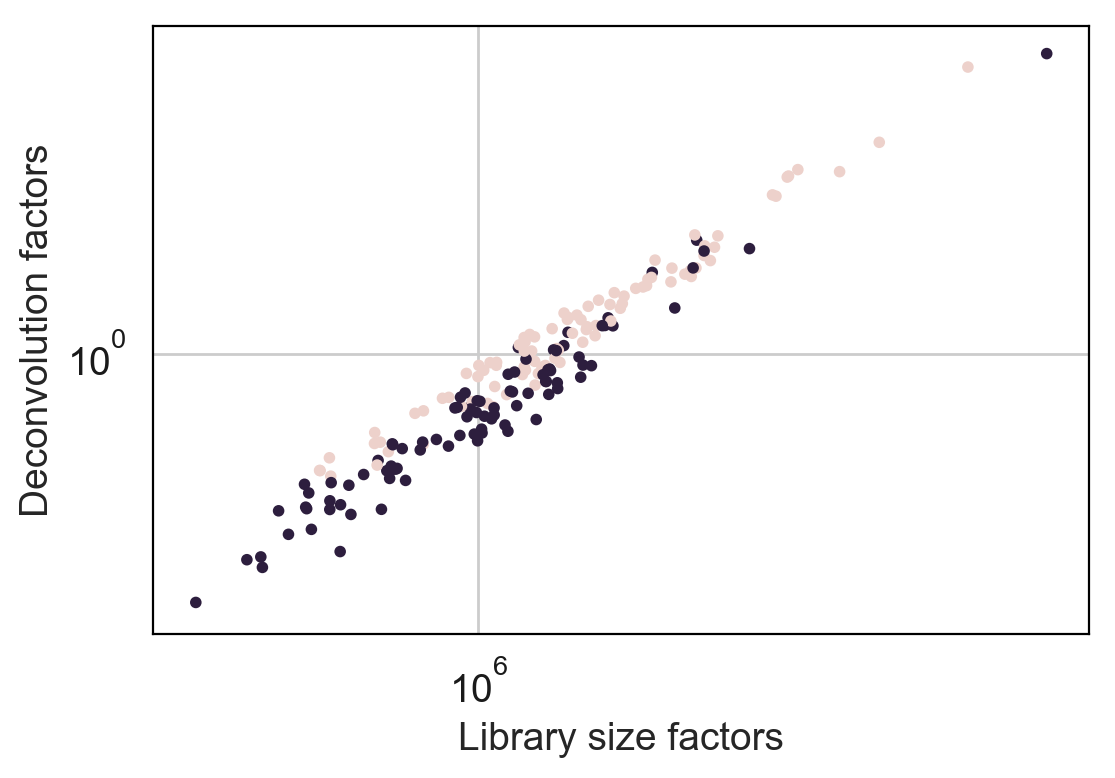

In [40]:
fig, ax = plt.subplots(figsize = (6,4))
ax.scatter(adata.obs['lib_size_factors'],adata.obs['size_factors'],c=induced, 
            cmap=sns.cubehelix_palette(as_cmap=True), s=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Deconvolution factors')
ax.set_xlabel('Library size factors')

## 4. Variance modeling
Done here in scanpy. Blocking needs to be done manually.

In [16]:
# Separate by batch
block1 = adata[adata.obs['block'] == 1].copy()
block2 = adata[adata.obs['block'] == 2].copy()

# top 10 percent of genes
n_genes = int(adata.X.shape[1]*0.1)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


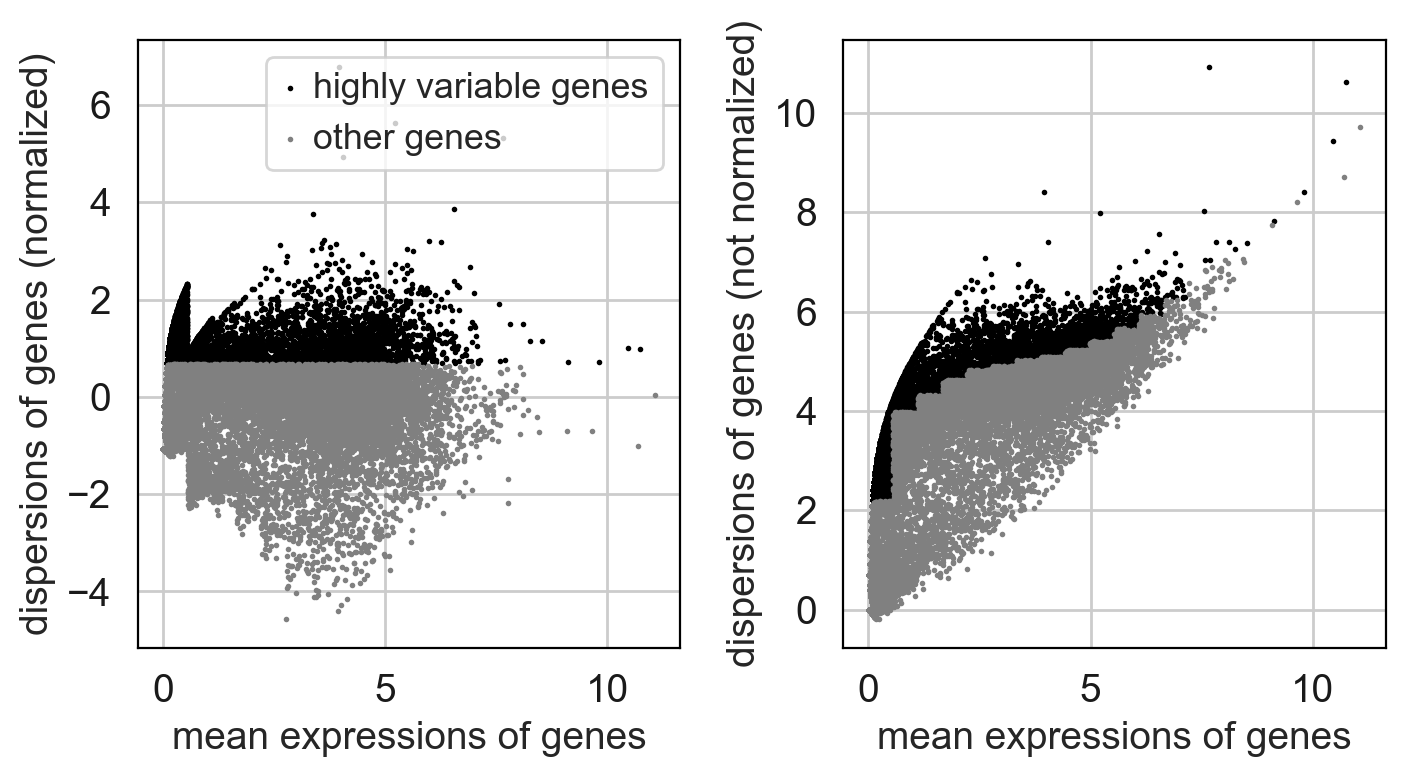

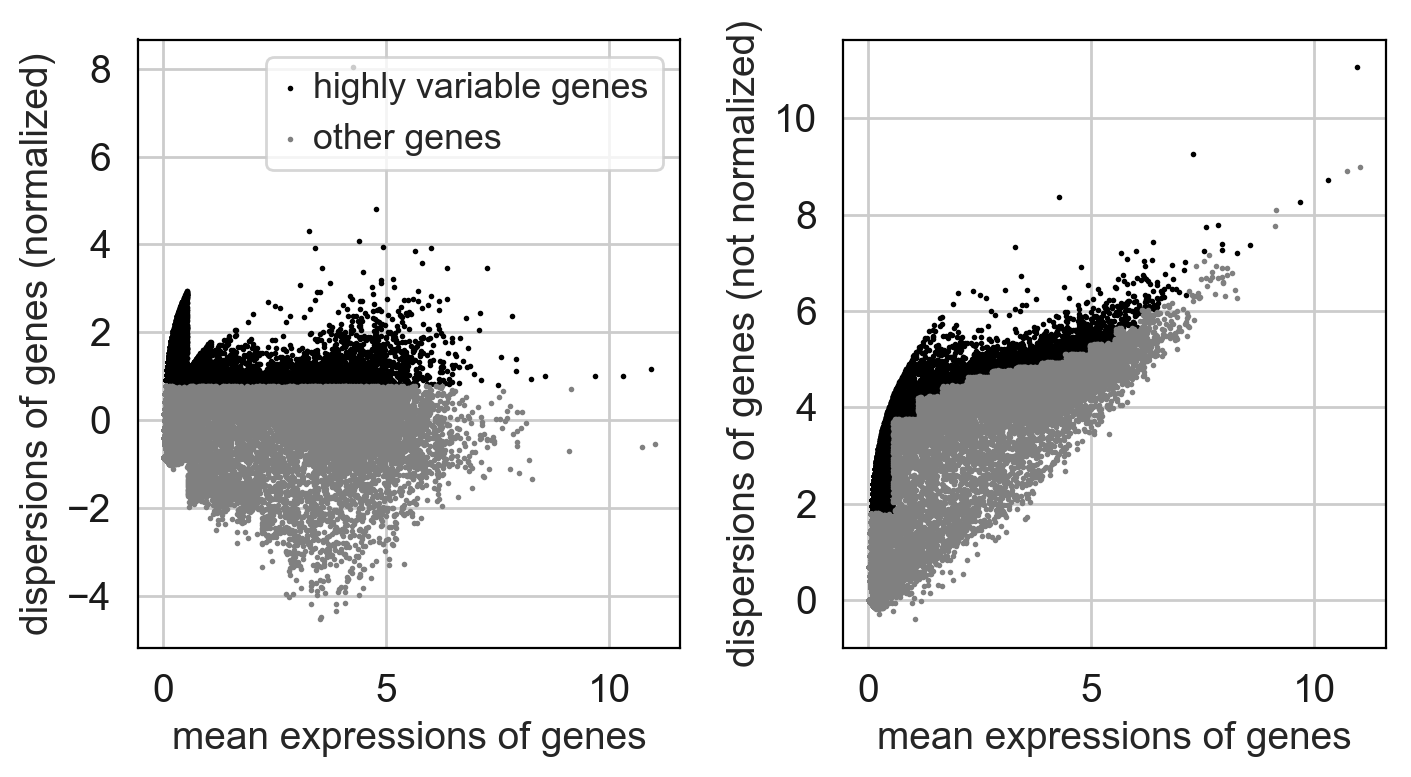

In [17]:
sc.pp.highly_variable_genes(block1, n_top_genes = n_genes)
sc.pp.highly_variable_genes(block2, n_top_genes = n_genes)

sc.pl.highly_variable_genes(block1)
sc.pl.highly_variable_genes(block2)

## 5. Batch correction
Done with scanpy.

In [18]:
sc.pp.combat(adata,key='block',covariates=None,inplace=True)

... storing 'cell line' as categorical
... storing 'cell type' as categorical
... storing 'single cell well quality' as categorical
... storing 'genotype' as categorical
... storing 'phenotype' as categorical
... storing 'strain' as categorical
... storing 'spike-in addition' as categorical
... storing 'SYMBOL' as categorical
... storing 'SEQNAME' as categorical


Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Found 22807 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



/Users/cshasha/.local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:338: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())
/Users/cshasha/.local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:338: RuntimeWarning: invalid value encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


## 6. Dimensionality reduction
Done with scanpy.

In [19]:
sc.pp.pca(adata,n_comps=10,random_state = 10)
sc.pp.neighbors(adata)
sc.tl.tsne(adata,n_pcs=10, perplexity=10,random_state = 10)

computing PCA with n_comps = 10
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)


## 7. Clustering
Leiden clustering with scanpy.

In [20]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


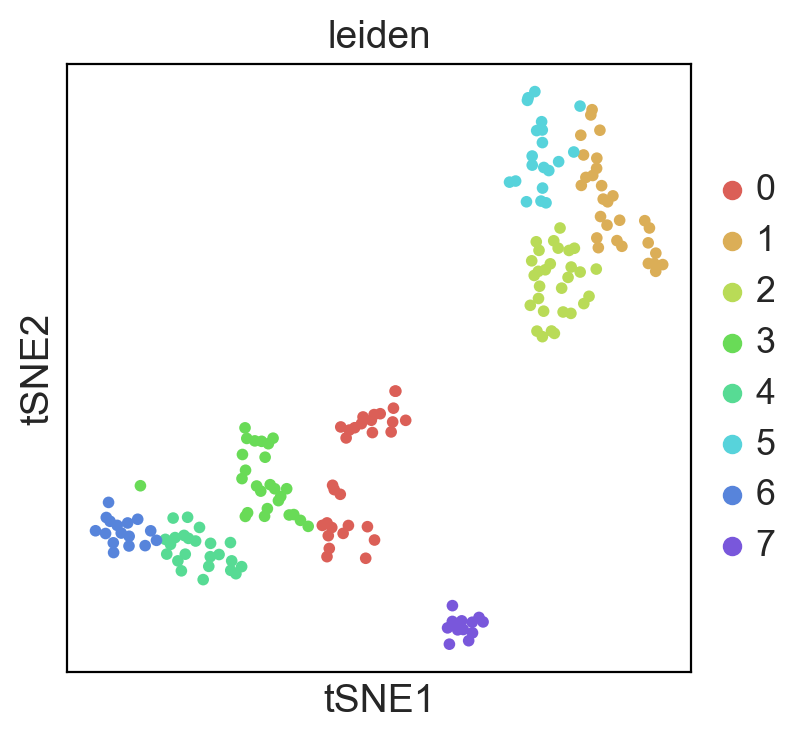

In [21]:
sc.pl.tsne(adata,color='leiden',palette=sns.color_palette("hls", 10),size=70)

## 8. Interpretation

In [22]:
# Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden', n_genes=10)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


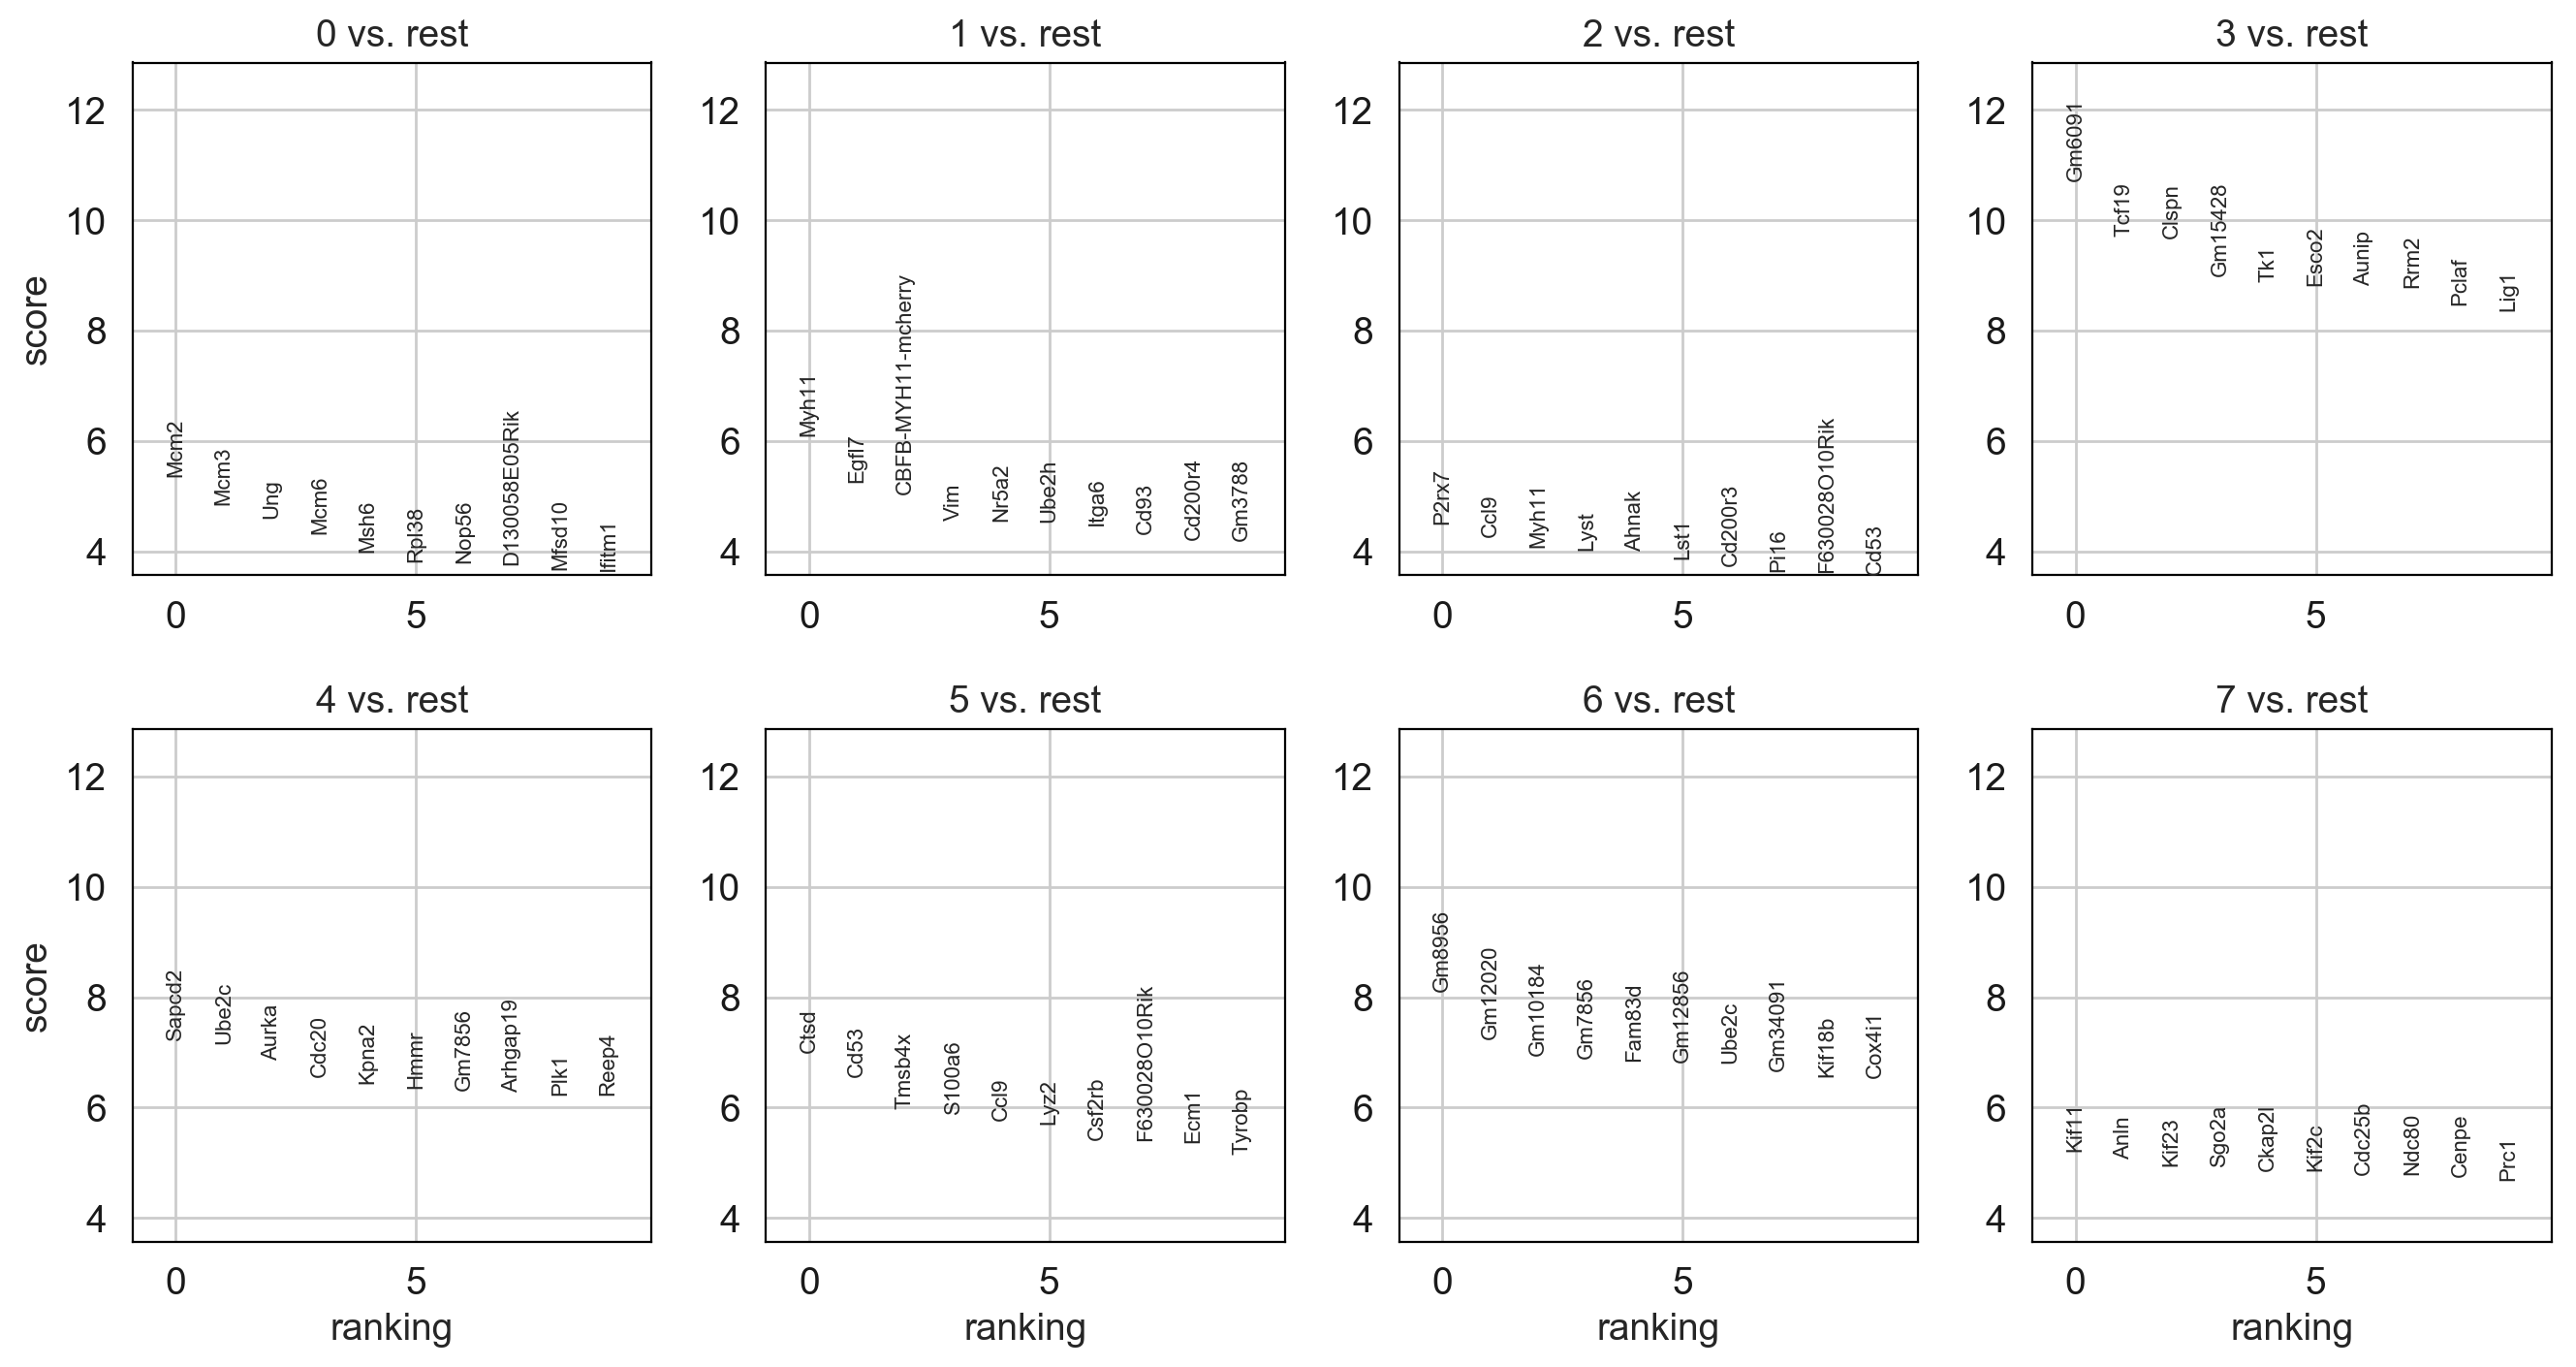

In [23]:
# Look at top genes
sc.pl.rank_genes_groups(adata)

In [24]:
sc.tl.dendrogram(adata,groupby='leiden')

    using 'X_pca' with n_pcs = 10
Storing dendrogram info using `.uns['dendrogram_leiden']`


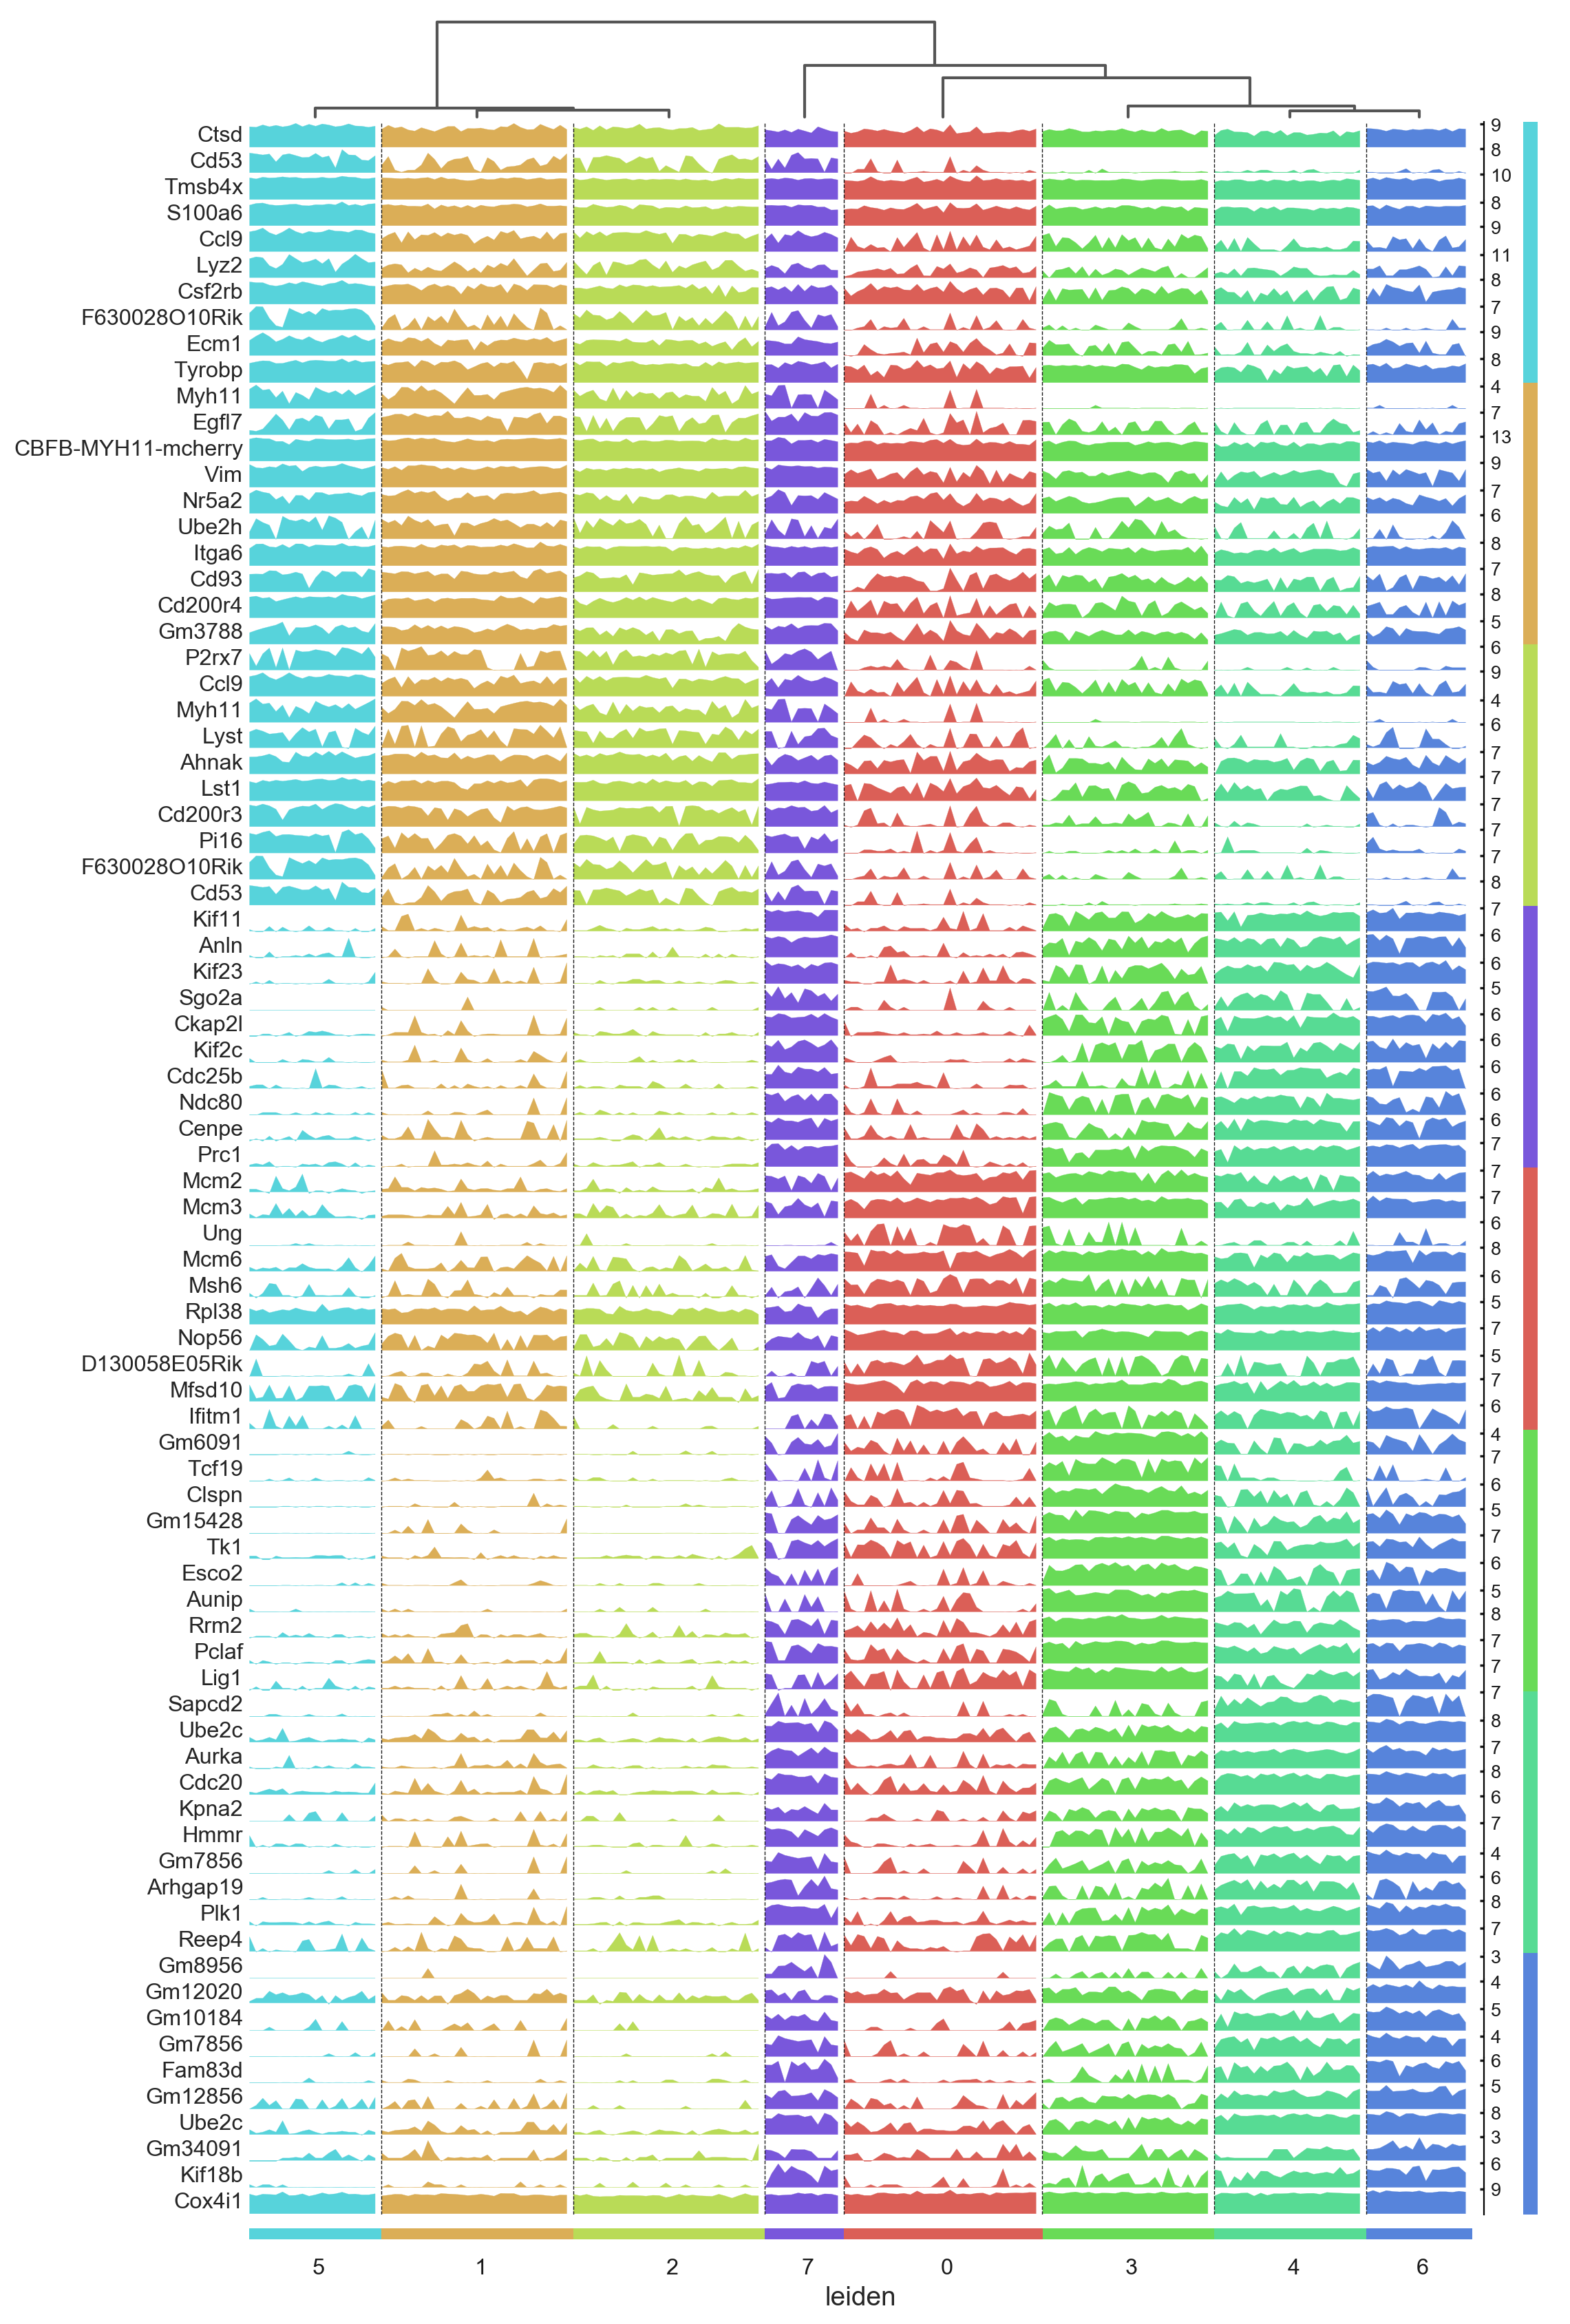

In [25]:
# Visualize
sc.pl.rank_genes_groups_tracksplot(adata,groupby='leiden')

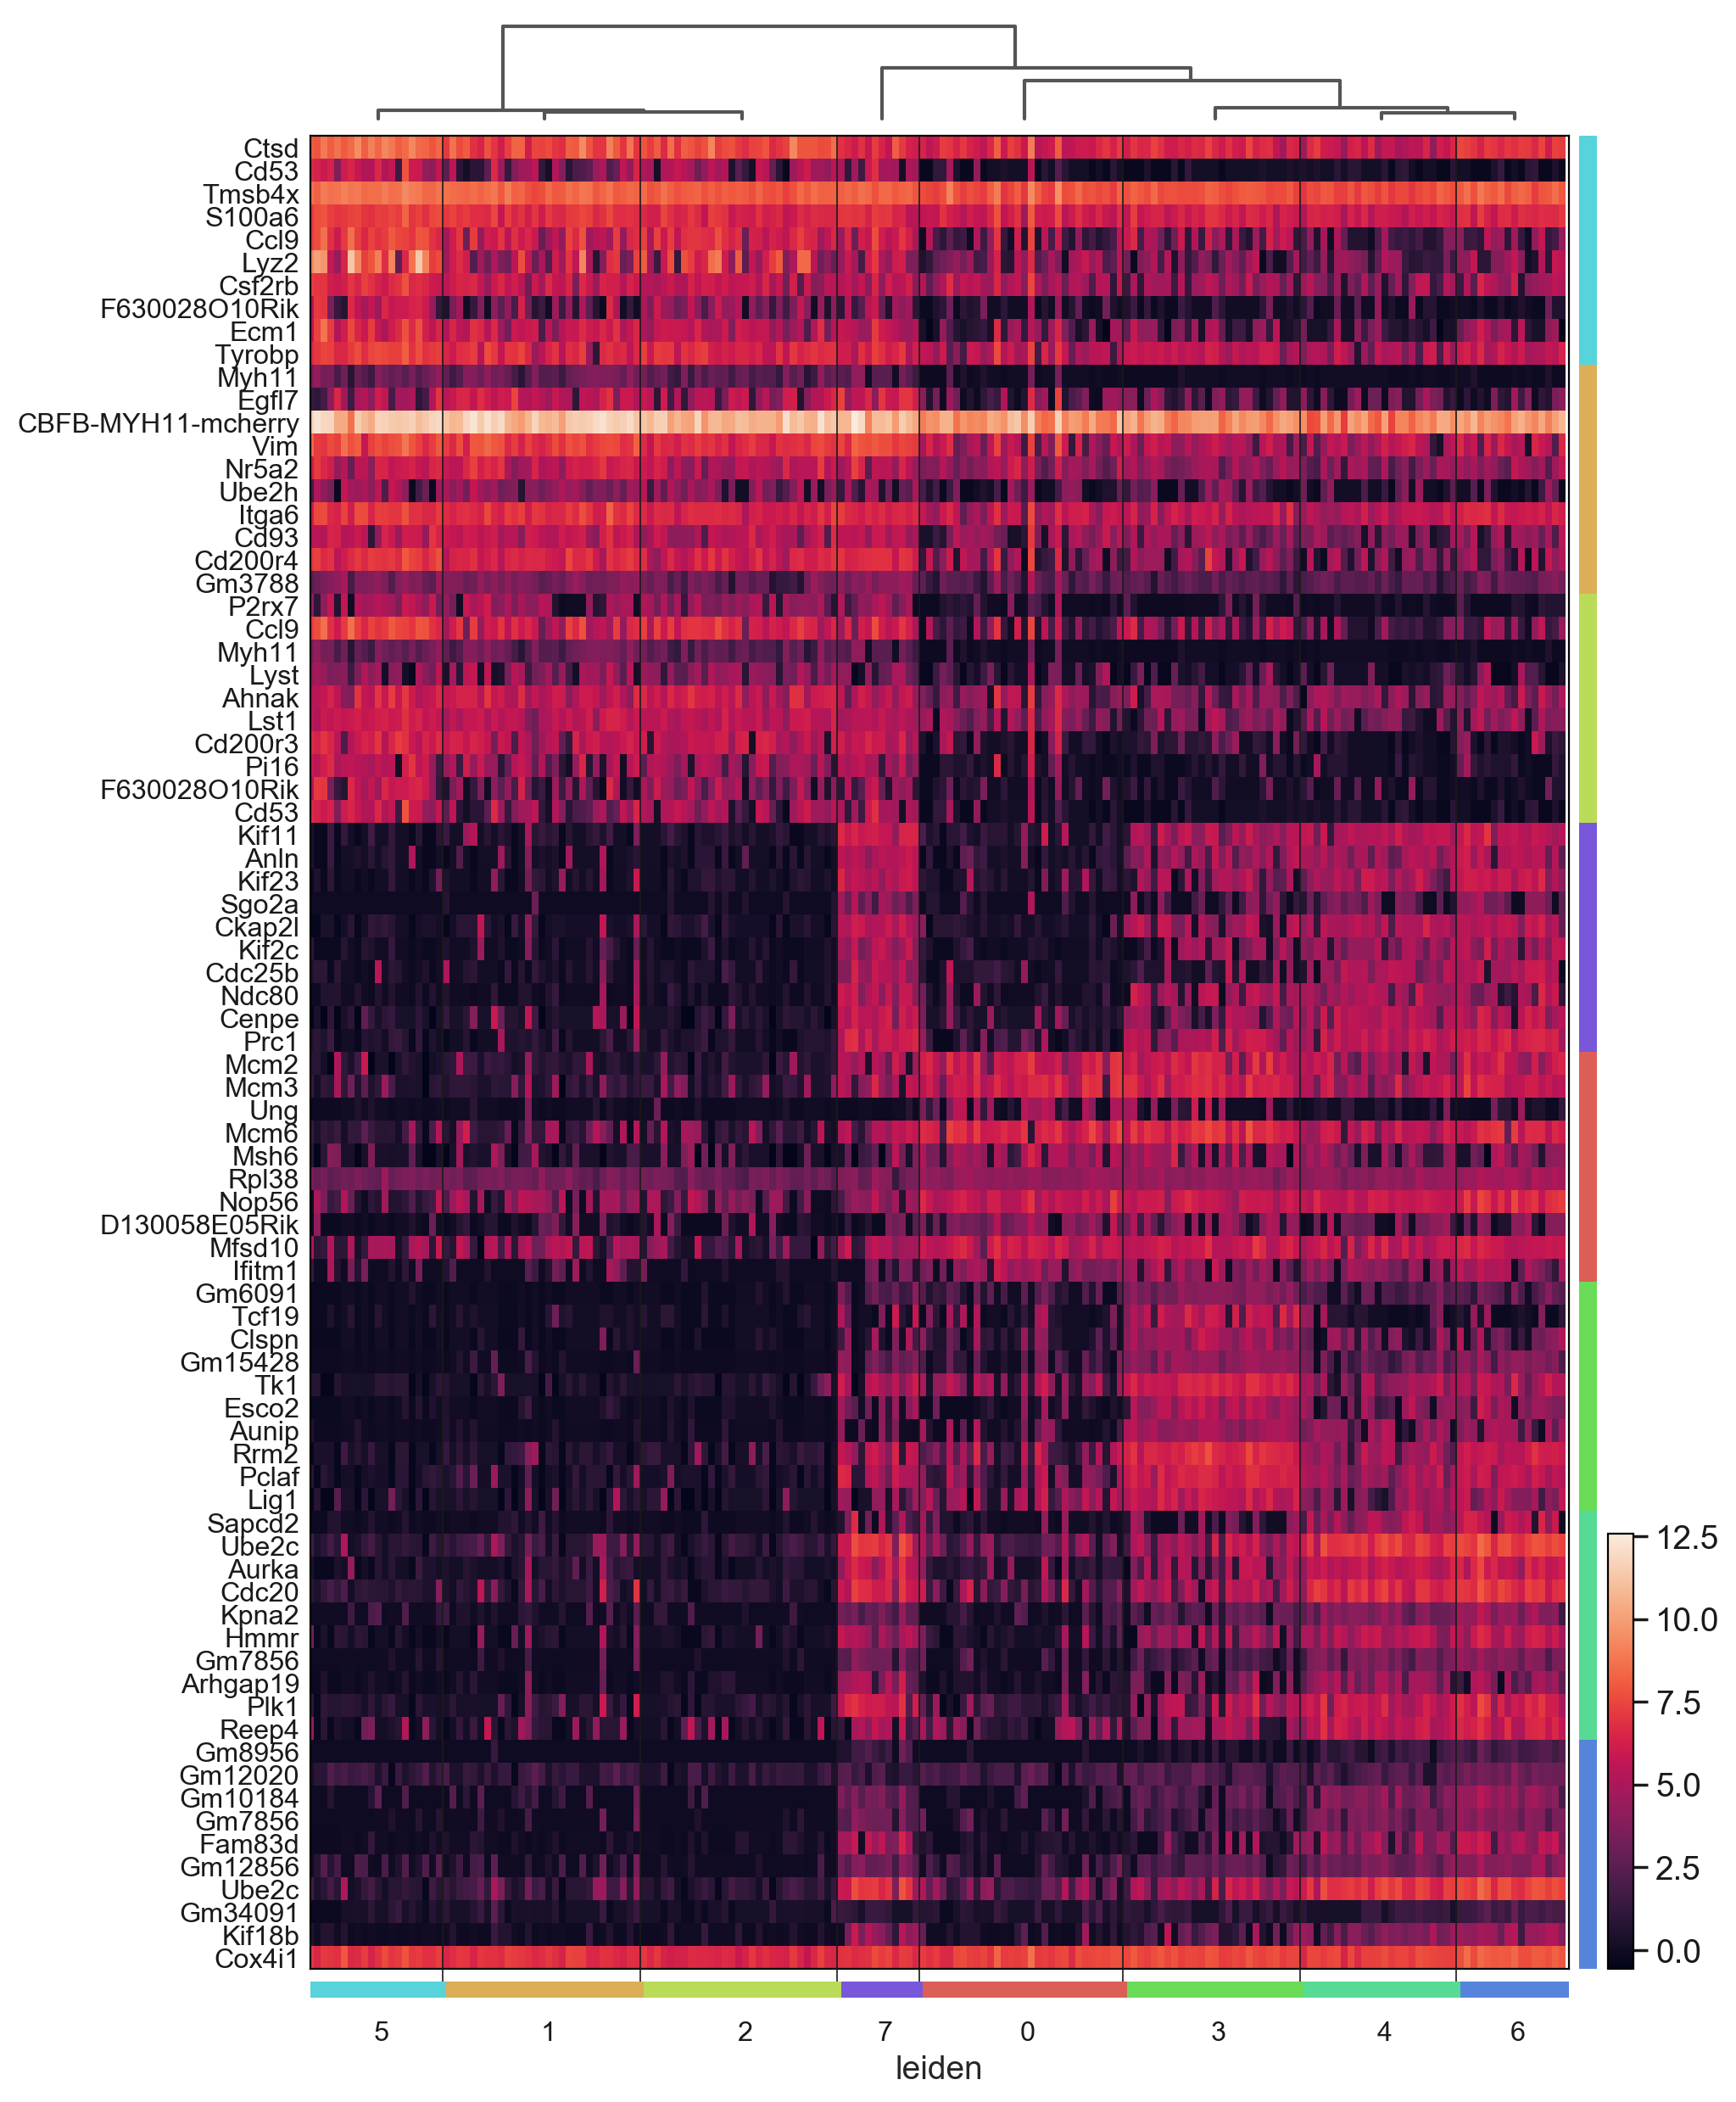

In [27]:
sc.pl.rank_genes_groups_heatmap(adata,groupby='leiden',swap_axes=True,show_gene_labels=True)